<a href="https://colab.research.google.com/github/Vaycold/Python_DL/blob/main/Image_Transformation/%EC%82%AC%EC%A7%84%ED%99%95%EB%8C%80%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Super Resolution

## Import the package & Load the data

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from google.colab import drive
from IPython.display import Image

warnings.filterwarnings('ignore')
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [2]:
dataset_path = 'MyDrive/MyDrive/fastcampus/DL_300/이미지변환/dataset'
pfcn_small = np.load(dataset_path + '/pfcn_small.npz')
train_big_images = pfcn_small['train_images']
test_big_images = pfcn_small['test_images']

## Preprocessing & Visualizing

In [3]:
train_big_images.shape

(1700, 100, 75, 3)

In [4]:
# resize로 작은 image 만들기
from skimage.transform import resize
train_small_images = np.array([resize(img, (50,37)) for img in train_big_images])
test_small_images = np.array([resize(img, (50,37)) for img in test_big_images])

In [5]:
train_small_images.shape

(1700, 50, 37, 3)

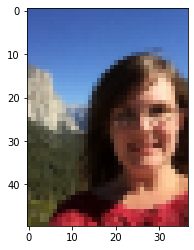

In [6]:
plt.imshow(train_small_images[0])

In [7]:
train_small_images.shape

(1700, 50, 37, 3)

In [8]:
train_small_images[0].shape

(50, 37, 3)

In [9]:
train_big_images.shape

(1700, 100, 75, 3)

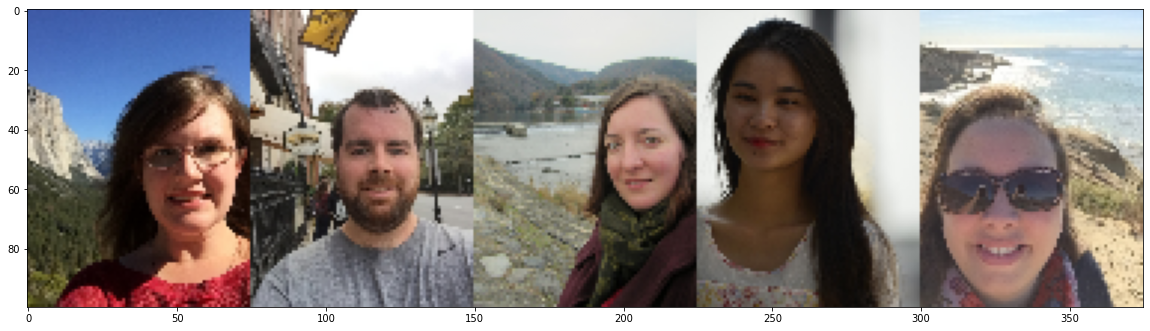

In [10]:
plt.figure(figsize=(20,6))
plt.imshow(train_big_images[:5].transpose((1,0,2,3)).reshape((100,-1,3)))
plt.show()

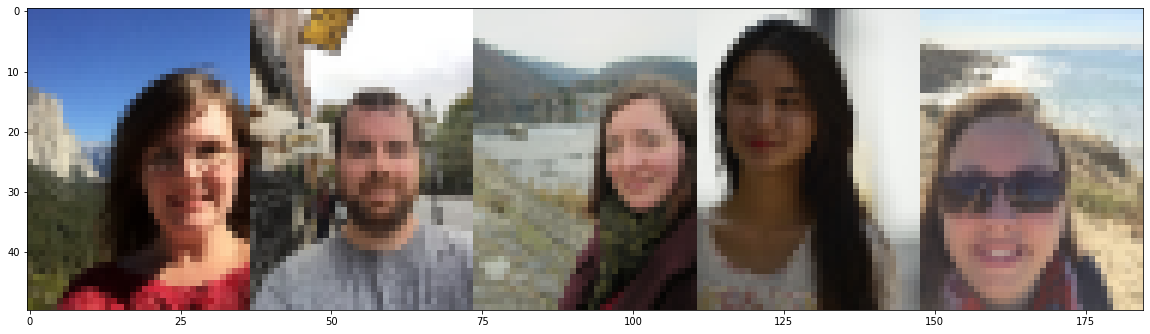

In [11]:
plt.figure(figsize=(20,6))
plt.imshow(train_small_images[:5].transpose((1,0,2,3)).reshape((50,-1,3)))
plt.show()

## Modeling

In [12]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

def conv2d_block(x, channel) :
    x = Conv2D(channel, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(channel, 3, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def unet_resolution() :           # 작은이미지가 들어가면 큰 이미지가 출력되게 끔
    inputs = Input((50,37,3))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)
     
    u6 = Conv2DTranspose(128, 2, 2, padding='valid', output_padding=(0,0))(c5)
    u6 = concatenate([u6,c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)
    
    u7 = Conv2DTranspose(64, 2, 2, padding='valid', output_padding=(0,1))(c6)
    u7 = concatenate([u7,c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)
    
    u8 = Conv2DTranspose(32, 2, 2, padding='valid', output_padding=(1,0))(c7)
    u8 = concatenate([u8,c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)
    
    u9 = Conv2DTranspose(16, 2, 2, padding='valid', output_padding=(0,1))(c8)
    u9 = concatenate([u9,c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)
    
    u10 = Conv2DTranspose(16, 2,2, padding='valid', output_padding=(0,1))(c9)
    outputs = Conv2D(3, 1, activation='sigmoid')(u10)
    
    model = Model(inputs, outputs) #c5
    return model


In [13]:
model = unet_resolution()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 37, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 37, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 50, 37, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 50, 37, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
model.compile(
    loss = 'mae', 
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [15]:
hist = model.fit(train_small_images, train_big_images,
          validation_data = (test_small_images, test_big_images),
          epochs = 25,
          verbose = 1)

Epoch 1/25
54/54 [==============================] - 37s 48ms/step - loss: 0.1986 - accuracy: 0.5012 - val_loss: 0.2039 - val_accuracy: 0.6748
Epoch 2/25
54/54 [==============================] - 1s 21ms/step - loss: 0.0779 - accuracy: 0.7069 - val_loss: 0.1735 - val_accuracy: 0.7088
Epoch 3/25
54/54 [==============================] - 1s 21ms/step - loss: 0.0664 - accuracy: 0.7572 - val_loss: 0.1584 - val_accuracy: 0.7263
Epoch 4/25
54/54 [==============================] - 1s 21ms/step - loss: 0.0637 - accuracy: 0.7692 - val_loss: 0.1452 - val_accuracy: 0.7190
Epoch 5/25
54/54 [==============================] - 1s 21ms/step - loss: 0.0612 - accuracy: 0.7739 - val_loss: 0.1183 - val_accuracy: 0.7393
Epoch 6/25
54/54 [==============================] - 1s 21ms/step - loss: 0.0601 - accuracy: 0.7689 - val_loss: 0.1066 - val_accuracy: 0.7510
Epoch 7/25
54/54 [==============================] - 1s 21ms/step - loss: 0.0590 - accuracy: 0.7858 - val_loss: 0.0809 - val_accuracy: 0.7495
Epoch 8/25
5

In [18]:
res = model.predict(test_small_images[1:2]) # modeling result
res.shape

(1, 100, 75, 3)

In [17]:
exp = resize(test_small_images[1], (100,75)) # manually expand
exp.shape

(100, 75, 3)

In [19]:
test_big_images[1].shape # goal

(100, 75, 3)

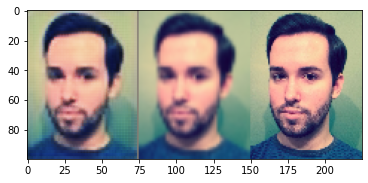

In [26]:
img = np.concatenate(
    [res[0], exp, test_big_images[1]], axis=1
)
img.shape
plt.imshow(img)
plt.show() # 1st fig(modeling) more clear than 2nd(manually expand)

In [34]:
# Compare with 3 fig
res_ = model.predict(test_small_images[:5])
res_.shape

(5, 100, 75, 3)

In [36]:
exps = np.array([resize(test_small_images[i], (100,75)) for i in range(5)])
exps.shape

(5, 100, 75, 3)

In [37]:
test_big_images[:5].shape

(5, 100, 75, 3)

In [39]:
five = np.concatenate(
    [res_, exps, test_big_images[:5]], axis=1
)
five.shape

(5, 300, 75, 3)

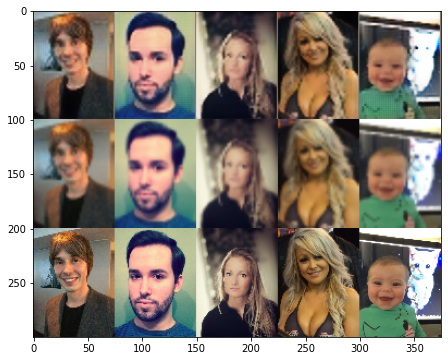

In [44]:
plt.figure(figsize=(20,6))
plt.imshow(five.transpose(1,0,2,3).reshape((300,-1,3)))
plt.show()

# SRCNN

In [53]:
from keras.layers import Average # 주어진 layer의 평균값을 내줌
def srcnn() :
    inputs = Input((100,75,3))
    x = Conv2D(64, 9 , activation='relu', padding = 'same')(inputs)

    x1 = Conv2D(32, 1 , activation='relu', padding = 'same')(x)
    x2 = Conv2D(32, 3 , activation='relu', padding = 'same')(x)
    x3 = Conv2D(32, 5 , activation='relu', padding = 'same')(x)
    x = Average()([x1,x2,x3]) # 3개의 다른 커널값으로 같은 이미지에 대해 분석한 것을 평균하겠다.
    
    outputs = Conv2D(3,5, activation='relu', padding='same')(x)
    model = Model(inputs, outputs)
    model.compile(
        loss = 'mae',
        optimizer = 'adam',
        metrics = ['accuracy']
    )
    return model

In [54]:
model2 = srcnn()
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 100, 75, 64)  15616       input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 100, 75, 32)  2080        conv2d_33[0][0]                  
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 100, 75, 32)  18464       conv2d_33[0][0]                  
____________________________________________________________________________________________